In [1]:
!python -V

Python 3.9.19


In [2]:
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [56]:
import pickle
import warnings
warnings.filterwarnings('ignore')

In [57]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("first-experiment")

<Experiment: artifact_location='/workspaces/mlops-practice/02-exp-tracking/mlruns/1', creation_time=1718246543216, experiment_id='1', last_update_time=1718246543216, lifecycle_stage='active', name='first-experiment', tags={}>

In [58]:
# !pip install pyarrow

In [59]:
print(f"pandas version = {pd.__version__}")
print(f"sklearn version = {sklearn.__version__}")

pandas version = 2.2.2
sklearn version = 1.5.0


In [60]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet')
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964624 entries, 0 to 2964623
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

In [62]:
df_filter = df.copy()
df_filter = df_filter.sample(n=50000).reset_index(drop=True)

In [63]:
# Duration (Dropoff - Pickup)
df_filter['duration'] = df_filter.tpep_dropoff_datetime -  df_filter.tpep_pickup_datetime
df_filter['duration'] = df_filter.duration.apply(lambda td: td.total_seconds()/ 60)
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


# Duration

In [64]:
df_filter.duration.describe()

count    50000.000000
mean        15.524056
std         31.432302
min         -0.500000
25%          7.133333
50%         11.725000
75%         18.666667
max       1437.216667
Name: duration, dtype: float64

In [65]:
df_filter.duration.describe(percentiles=[0.95,0.98,0.99])

count    50000.000000
mean        15.524056
std         31.432302
min         -0.500000
50%         11.725000
95%         37.868333
98%         50.617000
99%         60.417000
max       1437.216667
Name: duration, dtype: float64

In [66]:
# Filter the DataFrame to include only rows where duration > 0 and duration <= 120 minutes
df_filter = df_filter[(df_filter.duration > 0) & (df_filter.duration <= 120)]

In [67]:
df_filter.duration.max()

118.68333333333334

# Passenger Count

In [68]:
df_filter.passenger_count.describe()

count    47529.000000
mean         1.334070
std          0.841425
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          8.000000
Name: passenger_count, dtype: float64

In [69]:
# Filter the DataFrame to include only rows where passenger_count > 0
df_filter = df_filter[df_filter.passenger_count > 0]

# Fare Amount

In [70]:
df_filter.fare_amount.describe()

count    46971.000000
mean        18.009568
std         17.958714
min       -133.000000
25%          8.600000
50%         12.800000
75%         19.800000
max        353.000000
Name: fare_amount, dtype: float64

In [71]:
# Filter the DataFrame to include only rows where fare_amount > 0
df_filter = df_filter[df_filter.fare_amount > 0]

# trip_distance

In [72]:
df_filter.trip_distance.min()

0.0

In [73]:
df_filter = df_filter[df_filter.trip_distance > 0]

In [74]:
df_filter.trip_distance.min()

0.01

In [75]:
df_filter.reset_index(drop=True)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,duration
0,2,2024-01-18 17:15:37,2024-01-18 17:27:21,1.0,1.79,1.0,N,239,48,1,12.8,2.5,0.5,0.96,0.0,1.0,20.26,2.5,0.00,11.733333
1,2,2024-01-01 19:26:36,2024-01-01 19:34:38,3.0,4.49,1.0,N,132,219,3,19.1,0.0,0.5,0.00,0.0,1.0,22.35,0.0,1.75,8.033333
2,2,2024-01-06 22:26:19,2024-01-06 22:32:54,1.0,1.02,1.0,N,142,143,1,8.6,1.0,0.5,3.40,0.0,1.0,17.00,2.5,0.00,6.583333
3,1,2024-01-24 09:40:49,2024-01-24 09:44:30,2.0,0.60,1.0,N,24,41,2,5.8,0.0,0.5,0.00,0.0,1.0,7.30,0.0,0.00,3.683333
4,2,2024-01-19 23:45:19,2024-01-19 23:51:23,1.0,0.98,1.0,N,236,262,1,7.9,1.0,0.5,1.00,0.0,1.0,13.90,2.5,0.00,6.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45820,1,2024-01-30 13:42:37,2024-01-30 13:55:24,2.0,1.30,1.0,N,234,230,1,10.7,2.5,0.5,3.65,0.0,1.0,18.35,2.5,0.00,12.783333
45821,1,2024-01-01 02:05:53,2024-01-01 02:08:52,2.0,0.80,1.0,N,137,233,1,5.8,3.5,0.5,2.15,0.0,1.0,12.95,2.5,0.00,2.983333
45822,2,2024-01-29 20:00:52,2024-01-29 20:03:54,1.0,0.37,1.0,N,142,163,1,5.1,1.0,0.5,0.09,0.0,1.0,10.19,2.5,0.00,3.033333
45823,1,2024-01-12 07:57:39,2024-01-12 08:06:26,1.0,1.00,1.0,N,236,262,1,9.3,2.5,0.5,1.33,0.0,1.0,14.63,2.5,0.00,8.783333


In [76]:
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45825 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               45825 non-null  int32         
 1   tpep_pickup_datetime   45825 non-null  datetime64[us]
 2   tpep_dropoff_datetime  45825 non-null  datetime64[us]
 3   passenger_count        45825 non-null  float64       
 4   trip_distance          45825 non-null  float64       
 5   RatecodeID             45825 non-null  float64       
 6   store_and_fwd_flag     45825 non-null  object        
 7   PULocationID           45825 non-null  int32         
 8   DOLocationID           45825 non-null  int32         
 9   payment_type           45825 non-null  int64         
 10  fare_amount            45825 non-null  float64       
 11  extra                  45825 non-null  float64       
 12  mta_tax                45825 non-null  float64       
 13  tip_am

# Feature Selection

In [77]:
categorical = ['PULocationID','DOLocationID']
numerical = ['trip_distance']

In [78]:
df_filter[categorical].dtypes

PULocationID    int32
DOLocationID    int32
dtype: object

In [79]:
df_filter[categorical] = df_filter[categorical].astype(str)

In [80]:
df_filter[categorical].dtypes

PULocationID    object
DOLocationID    object
dtype: object

In [81]:
train_dicts = df_filter[categorical + numerical].to_dict(orient='records')

In [82]:
train_dicts

[{'PULocationID': '239', 'DOLocationID': '48', 'trip_distance': 1.79},
 {'PULocationID': '132', 'DOLocationID': '219', 'trip_distance': 4.49},
 {'PULocationID': '142', 'DOLocationID': '143', 'trip_distance': 1.02},
 {'PULocationID': '24', 'DOLocationID': '41', 'trip_distance': 0.6},
 {'PULocationID': '236', 'DOLocationID': '262', 'trip_distance': 0.98},
 {'PULocationID': '137', 'DOLocationID': '161', 'trip_distance': 1.36},
 {'PULocationID': '144', 'DOLocationID': '114', 'trip_distance': 0.7},
 {'PULocationID': '142', 'DOLocationID': '140', 'trip_distance': 2.3},
 {'PULocationID': '186', 'DOLocationID': '234', 'trip_distance': 1.29},
 {'PULocationID': '142', 'DOLocationID': '239', 'trip_distance': 0.9},
 {'PULocationID': '153', 'DOLocationID': '95', 'trip_distance': 14.5},
 {'PULocationID': '239', 'DOLocationID': '75', 'trip_distance': 1.7},
 {'PULocationID': '142', 'DOLocationID': '234', 'trip_distance': 2.1},
 {'PULocationID': '143', 'DOLocationID': '143', 'trip_distance': 0.6},
 {'P

In [83]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [84]:
X_train

<45825x448 sparse matrix of type '<class 'numpy.float64'>'
	with 137475 stored elements in Compressed Sparse Row format>

In [85]:
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=11',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=115',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',
 'DOLocationID=145',
 'DOLocationID=146',
 'DOLocationID=147',

In [86]:
target = 'duration'
y_train =df_filter[target].values

In [87]:
y_train

array([11.73333333,  8.03333333,  6.58333333, ...,  3.03333333,
        8.78333333, 21.61666667])

In [88]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [89]:
y_pred = lr.predict(X_train)

# Evaluation

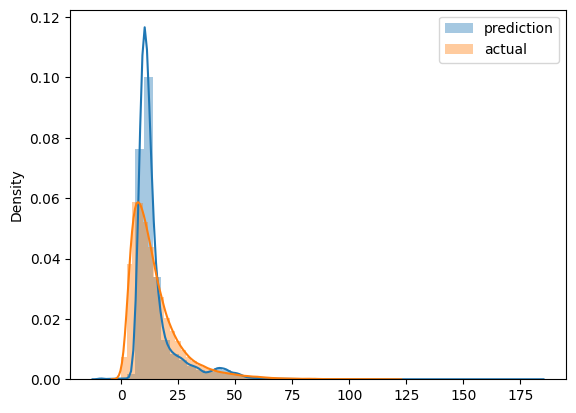

In [90]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [91]:
y_pred

array([11.61735437, 11.56348051,  9.12657881, ...,  8.22068601,
        8.60358436, 17.48594884])

In [92]:
y_pred.max()

181.70361482757215

In [93]:
# Creating a new DataFrame df_predict
df_predict = pd.DataFrame()
df_predict['duration'] = df_filter.duration
df_predict['duration_prediction'] = y_pred

In [94]:
df_predict

,duration,duration_prediction
0,11.733333,11.617354
2,8.033333,11.563481
3,6.583333,9.126579
4,3.683333,7.994566
5,6.066667,8.549168
...,...,...
49994,12.783333,12.916187
49995,2.983333,7.648899
49996,3.033333,8.220686
49998,8.783333,8.603584


In [95]:
df_predict[df_predict['duration_prediction'] >= 100 ]

,duration,duration_prediction
2078,74.666667,181.703615
2425,64.350000,112.937949
9087,62.950000,144.680027
12226,108.366667,107.862150
13272,69.466667,102.516880
20454,64.616667,131.684267
32228,104.033333,104.527422
32968,102.583333,100.299299
38850,100.550000,100.642320
39040,109.250000,100.133906


In [96]:
mean_squared_error(y_train,y_pred,squared = False)

6.390290337397437

In [108]:
def read_df(filename):
    df = pd.read_parquet(filename)
    
    df_filter = df.copy()
    df_filter = df_filter.sample(n=50000).reset_index(drop=True)
    
    df_filter['duration'] = df_filter.tpep_dropoff_datetime -  df_filter.tpep_pickup_datetime
    df_filter['duration'] = df_filter.duration.apply(lambda td: td.total_seconds()/ 60)

    df_filter = df_filter[(df_filter.duration > 0) & (df_filter.duration <= 120)]
    df_filter = df_filter[df_filter.passenger_count > 0]
    df_filter = df_filter[df_filter.fare_amount > 0]
    df_filter = df_filter[df_filter.trip_distance > 0]
    
    df_filter.reset_index(drop=True)
    
    categorical = ['PULocationID','DOLocationID']
    numerical = ['trip_distance']
    
    df_filter[categorical] = df_filter[categorical].astype(str)
    
    return df_filter
    

In [109]:
df_train = read_df('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet') # January
df_val = read_df('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-02.parquet') # February

In [110]:
len(df_train), len(df_val)

(45907, 45157)

In [111]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [112]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [113]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [114]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

6.591458593541191

In [115]:
print(f"MAPE ={mean_absolute_percentage_error(y_val, y_pred)}")

MAPE =0.410092089344326


In [116]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.224398901479908

In [117]:
print(f"MAPE ={mean_absolute_percentage_error(y_val, y_pred)}")

MAPE =0.5884934310010169


In [118]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [121]:
with mlflow.start_run():

    mlflow.set_tag("developer","ahmadluay")

    mlflow.log_param("train-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet")
    mlflow.log_param("valid-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-02.parquet")    

    alpha = 0.01
    mlflow.log_param("alpha", alpha)    
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_val)    
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("MAPE", mape)
    